In [90]:
!nvidia-smi

Wed Oct 16 17:22:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              27W /  70W |    259MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D,
                          GlobalAveragePooling1D)
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

In [93]:
data_path = '/content/drive/MyDrive/spam.csv'
data = pd.read_csv(data_path, encoding='latin-1')

In [94]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [95]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [96]:
data.columns = ['label', 'message']

In [97]:
data['message_len'] = data['message'].apply(lambda x:len(x.split(' ')))
data.head()

,label,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [98]:
max(data['message_len'])

171

In [99]:
balance_count = data.groupby('label')['label'].agg('count').values
balance_count

array([4825,  747])

In [100]:
def data_cleaning(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [101]:
nltk.download('all')
stop_words = set(stopwords.words('english'))
more_stp_words = ['u', 'im', 'c']
stop_words = stop_words.union(more_stp_words)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [102]:
!python --version

Python 3.10.12


In [103]:
stemmer = nltk.SnowballStemmer('english')
def stem_words(text):
  return ' '.join([stemmer.stem(word) for word in text.split()])

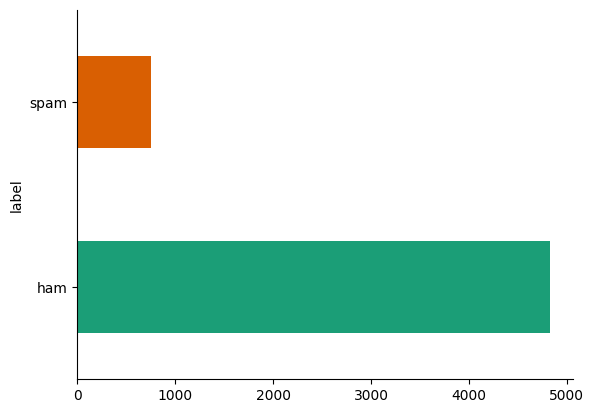

In [104]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [105]:
def data_preprocessing(text):
  text = data_cleaning(text)
  text = stem_words(text)
  return text

In [106]:
data['message_clean'] = data['message'].apply(lambda x: data_preprocessing(x))
data.head()

,label,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazi avail onli in bugi...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri in a wkli comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so earli hor u c alreadi then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goe to usf he live around ...


In [107]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['label'])
data.head()


,label,message,message_len,message_clean,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazi avail onli in bugi...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri in a wkli comp to win fa cup final ...,1
3,ham,U dun say so early hor... U c already then say...,11,u dun say so earli hor u c alreadi then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goe to usf he live around ...,0


In [108]:
X = data['message_clean']
y = data['label_encoded']

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [111]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [112]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [113]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<4457x6062 sparse matrix of type '<class 'numpy.float64'>'
	with 55413 stored elements in Compressed Sparse Row format>

In [114]:
texts = data['message_clean']
labels = data['label_encoded']

In [115]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6873

In [116]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[  24,  441, 3308, ...,    0,    0,    0],
       [  48,  327,  633, ...,    0,    0,    0],
       [  49,  456,   10, ...,    0,    0,    0],
       ...,
       [6871,   64,   10, ...,    0,    0,    0],
       [   5,  220,  117, ...,    0,    0,    0],
       [2109,    8,  477, ...,    0,    0,    0]], dtype=int32)

In [117]:
embeddings_dictionary = dict()
embedding_dim = 100
with open('/content/drive/MyDrive/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [118]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [119]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
new_embedding_dim = 100
svd = TruncatedSVD(n_components=new_embedding_dim, n_iter=7, random_state=42)
reduced_embedding_matrix = svd.fit_transform(embedding_matrix)
reduced_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-5.38289516, -0.30610522, -0.09794809, ...,  0.01309386,
         0.14279253,  0.06122622],
       [-5.32431911,  2.49432372, -0.32891899, ...,  0.08645299,
         0.02932145, -0.10148443],
       ...,
       [-1.24462863,  0.79380243,  0.2670966 , ...,  0.1862782 ,
        -0.3094643 ,  0.12481116],
       [ 1.63774244,  0.53200715,  0.2909991 , ...,  0.05509562,
        -0.07268549,  0.0515632 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [120]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix = cosine_similarity(reduced_embedding_matrix)
cosine_similarity_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.60836671, ...,  0.14888065,
        -0.4114358 ,  0.        ],
       [ 0.        ,  0.60836671,  1.        , ...,  0.31154552,
        -0.34231823,  0.        ],
       ...,
       [ 0.        ,  0.14888065,  0.31154552, ...,  1.        ,
        -0.097585  ,  0.        ],
       [ 0.        , -0.4114358 , -0.34231823, ..., -0.097585  ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    labels,
    test_size=0.25
)

In [ ]:
embedding_matrix.shape

In [123]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │         687,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,300 (2.62 MB)

 Trainable params: 687,300 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)


Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8656 - loss: 0.3434
Epoch 1: val_loss improved from inf to 0.24238, saving model to /content/drive/MyDrive/model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 706ms/step - accuracy: 0.8660 - loss: 0.3427 - val_accuracy: 0.9397 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9470 - loss: 0.1765
Epoch 2: val_loss improved from 0.24238 to 0.14344, saving model to /content/drive/MyDrive/model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 638ms/step - accuracy: 0.9471 - loss: 0.1763 - val_accuracy: 0.9497 - val_loss: 0.1434 - learning_rate: 0.0010
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9663 - loss: 0.1203
Epoch 3: val_loss improved from 0.14344 to 0.09028, saving model to /content/drive/MyDrive/model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 651ms/step - accuracy: 0.9663 - loss: 0.1202 - val_accuracy: 0.9749 - val_loss: 0.0903 - learning_rate: 0.0010


In [125]:
!pip install gradio

In [128]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/model.keras')


def preprocess_input(text):
    MAX_LENGTH = 100
    sequence = word_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH)
    return padded_sequence

def predict(text):
    processed_input = preprocess_input(text)
    prediction = model.predict(processed_input)
    return "Spam" if prediction > 0.5 else "Not Spam"

# Create a Gradio interface
gradio_app = gr.Interface(
    fn=predict,
    inputs="textbox",
    outputs="text",
    title="Spam Detection Model",
    description="Enter a message to check if it's spam or not."
)

# Launch Gradio using CLI
if __name__ == "__main__":
    gradio_app.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3985f9d049d7eba2b7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
